In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time


from numpy.linalg import norm 
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix


1.  load data
-   sgd
-  threshold
-  drop 0
- error function
- SGD function
- solver for matrix 

# Loading data

In [2]:
dataFile='data\BX-Book-Ratings.csv'

df = pd.read_csv(dataFile,sep=";",
                 header=0,
                 names=["user","isbn","rating"],
                 encoding='iso-8859-1',
                 nrows=1000
                )
df.head()

,user,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
def loadingData(dataFile,nrows=None):
    
#     if nrows =-1
    
    
    df = pd.read_csv(dataFile,
                     sep=";",
                     header=0,
                     names=["user","isbn","rating"],
                     encoding='iso-8859-1',
                     nrows=nrows
                    )
    return df

# Preprocessing 
-  select input dataset size


In [4]:
# does not work on whole data set coz its too large
# R = df.pivot(index='user',columns='isbn',values='rating')

encountered memory error
dropping zeros

In [5]:
print(df.shape)
df = df[df.rating!=0]
df.shape

(1000, 3)


(483, 3)

still memory error
filter unpopular books?
fileter lazy users?

In [6]:
# sparse matrix works more efficiently
df['rating'] = df['rating'].astype(float)
df['user'] = df['user'].astype("category")
df['isbn'] = df['isbn'].astype("category")

# convert str to catergory codes because spare matrix cannot contain string
isbn_code = df['isbn'].cat.codes.copy()
user_code = df['user'].cat.codes.copy()

R = coo_matrix((df['rating'],(user_code, isbn_code)))
R.shape

(127, 478)

In [7]:
def covertToSparse(df):
    # sparse matrix works more efficiently
    df['rating'] = df['rating'].astype(float)
    df['user'] = df['user'].astype("category")
    df['isbn'] = df['isbn'].astype("category")

    # convert str to catergory codes because spare matrix cannot contain string
    isbn_code = df['isbn'].cat.codes.copy()
    user_code = df['user'].cat.codes.copy()

    R = coo_matrix((df['rating'],(user_code, isbn_code)))
    
    return R

# SGD to solve for P and Q

error = R - R_hat
=> R = Q @ P.T

qi =  qi + gamma * (error @ pi - lambda @ qi)
pi =  pi + gamma * (error @ qi - lambda @ pi)

In [8]:
# element by element approach

def SGD(R,K=5,lambda_=0.02,steps=10,gamma=0.001,verbose=False,rmse_target=1):

    # lambda_: regularization
    # gamma :learning rate
    
    # initialise matrix P and Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(K,N)
    
    #initial RMSE
    rmse = np.sqrt(mean_squared_error(R.toarray(), P@Q))
    print(f"STARTING RMSE: {rmse:.2f}")

    for step in range(steps):
        
        for ui in range(len(R.data)):
            rui = R.data[ui] # serialize matrix
            u = R.row[ui] # get user index (row)
            i = R.col[ui] # get item index (col)

#             # adding bias
#             mean = np.mean(R.data) # mean score of all rating
#             ui = np.mean(P[u,:]) # mean rating given by that user
#             bi = np.mean(Q[:,i]) # mean rating give to that movie

#             bui = mean + ui + bi
            
#             rui_hat = P[u,:] @ Q[:,i] + mean + ui + bi
            rui_hat = P[u,:] @ Q[:,i] # sum(row x col)
            error = rui - rui_hat

            # update P,Q matrix
            P[u,:] = P[u,:] + gamma * (error * Q[:,i] - lambda_ * P[u,:])  
            Q[:,i] = Q[:,i] + gamma * (error * P[u,:] - lambda_ * Q[:,i])  

            
        rmse = np.sqrt(mean_squared_error(R.toarray(), P@Q))

        if verbose:
            print(f"STEP NO: {step+1} - CURRENT RMSE:{rmse:.2f}")
            
        if rmse < rmse_target:
            break
            
    if verbose:
        print(f"STEP NO: {step+1} - CURRENT RMSE:{rmse:.2f}")

    return P,Q,rmse

In [9]:
# element by element approach

def SGD_bias(R,K=5,lambda_=0.02,steps=10,gamma=0.001,verbose=False,rmse_target=1):

    # lambda_: regularization
    # gamma :learning rate
    
    # initialise matrix P and Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(K,N)
    
    #initial RMSE
    rmse = np.sqrt(mean_squared_error(R.toarray(), P@Q))
    print(f"STARTING RMSE: {rmse:.2f}")

    for step in range(steps):
        
        for ui in range(len(R.data)):
            rui = R.data[ui] # serialize matrix
            u = R.row[ui] # get user index (row)
            i = R.col[ui] # get item index (col)

            # adding bias
            mean = np.mean(R.data) # mean score of all rating
            ui = np.mean(P[u,:]) # mean rating given by that user
            bi = np.mean(Q[:,i]) # mean rating give to that movie

            bui = mean + ui + bi
            
            rui_hat = P[u,:] @ Q[:,i] + mean + ui + bi
            error = rui - rui_hat

            # update P,Q matrix
            P[u,:] = P[u,:] + gamma * (error * Q[:,i] - lambda_ * P[u,:])  
            Q[:,i] = Q[:,i] + gamma * (error * P[u,:] - lambda_ * Q[:,i])  

            
        rmse = np.sqrt(mean_squared_error(R.toarray(), P@Q))

        if verbose:
            print(f"STEP NO: {step+1} - CURRENT RMSE:{rmse:.2f}")
            
        if rmse < rmse_target:
            break
            
    if verbose:
        print(f"STEP NO: {step+1} - CURRENT RMSE:{rmse:.2f}")

    return P,Q,rmse

In [25]:
def cal_error(R,P,Q,lambda_=0.02):
    # error function to be minimized
    ratings = R.data
    rows = R.row
    cols = R.col
    error = 0
    
    for ui in range(len(ratings)):
        rui = ratings[ui]
        u= rows[ui]
        i= cols[ui]
        
        # adding bias
        mean = np.mean(R.data) # mean score of all rating
        ui = np.mean(P[u,:]) # mean rating given by that user
        bi = np.mean(Q[:,i]) # mean rating give to that movie
        bui = mean + ui + bi
        
        if rui > 0:
            rui_hat = P[u,:]@Q[:,i] + mean + ui + bi
#             norm_target = [ui,bi,P[u,:],Q[:,i]]
            terms = [ui,bi,norm(P[u,:],2),norm(Q[:,i],2)]
            error = error + (rui - rui_hat)**2 + \
                    lambda_ * sum([i**2 for i in terms])

    return error

def SGD_bias2(R,K=5,lambda_=0.02,steps=10,gamma=0.001,verbose=False,rmse_target=1):

    # lambda_: regularization
    # gamma :learning rate
    
    # initialise matrix P and Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(K,N)
    
    #initial RMSE
    rmse = np.sqrt(cal_error(R,P,Q,lambda_)/len(R.data))
    print(f"STARTING RMSE: {rmse:.2f}")

    for step in range(steps):
        
        for ui in range(len(R.data)):
            rui = R.data[ui] # serialize matrix
            u = R.row[ui] # get user index (row)
            i = R.col[ui] # get item index (col)

            # adding bias
            mean = np.mean(R.data) # mean score of all rating
            ui = np.mean(P[u,:]) # mean rating given by that user
            bi = np.mean(Q[:,i]) # mean rating give to that movie
            bui = mean + ui + bi
    


            # update P,Q matrix
            rui_hat = P[u,:]@Q[:,i] + mean + ui + bi
            eui = rui - rui_hat
            P[u,:] = P[u,:] + gamma * (eui * Q[:,i] - lambda_ * P[u,:])  
            Q[:,i] = Q[:,i] + gamma * (eui * P[u,:] - lambda_ * Q[:,i])  

            
        rmse = np.sqrt(cal_error(R,P,Q,lambda_)/len(R.data))

        if verbose:
            print(f"STEP NO: {step+1} - CURRENT RMSE:{rmse:.2f}")
            
        if rmse < rmse_target:
            break
            
    if verbose:
        print(f"STEP NO: {step+1} - CURRENT RMSE:{rmse:.2f}")

    return P,Q,rmse

In [19]:
# R = np.array([[3,0,2],[4,1,9],[9,2,1]])
M,N = R.shape
K=10
P = np.random.rand(M,K)
Q = np.random.rand(K,N)
cal_error(R,P,Q,0.02)

8167.446482021246

# Production

In [ ]:
starttime = time.time()

dataFile='data\BX-Book-Ratings.csv'
# nrows = None
nrows= 500

df = loadingData(dataFile,nrows)

print(f"DF SIZE: {df.shape}")
df = df[df.rating!=0]
print(f"DF SIZE AFTER DROPPING 0: {df.shape}")

R = covertToSparse(df)

print(f"Rating Matrix shape: {R.shape}")

params = {'R':R,
          'K':5,
          'lambda_':0.02,
          'steps':10,
          'gamma':0.001,
          'verbose':True,
          'rmse_target':1
         }


# P,Q,rmse = SGD(**params)
P,Q,rmse = SGD_bias2(**params)

duration = time.time() - starttime
print(f"Process time: {duration:.2f}")

DF SIZE: (1149780, 3)
DF SIZE AFTER DROPPING 0: (433671, 3)
Rating Matrix shape: (77805, 185973)



# how to input new user?

layer 1: user demographic, bio
user content based filtering to generate

layer 2: punch in social media account, obtain social graph 
recommend using colaborative filtering

layer 3: rate some movies to cold start the LFA process

save and load trained weiights, PQ
save and display rating matrix
load rating matrix to predicut user behaviour

# Misc code

In [118]:
import os
os.startfile(os.getcwd())

In [64]:
# element by element approach

def SGD_old(R,K=5,lambda_=0.02,steps=10,gamma=0.001,verbose=False,rmse_target=1):
# def SGD(R,K,lambda_,steps,gamma,verbose,rmse_target):    
    # lambda_: regularization
    # gamma :learning rate

    # initialise matrix P and Q
    M,N = R.shape
    P = np.random.rand(M,K)
    Q = np.random.rand(K,N)
    
    #initial RMSE
    rmse = np.sqrt(mean_squared_error(R.toarray(), P@Q))
    print(f"STARTING RMSE: {rmse:.2f}")

    for step in range(steps):
        for ui in range(len(R.data)):
            rui = R.data[ui] # serialize matrix
            u = R.row[ui] # get user index (row)
            i = R.col[ui] # get item index (col)

            rui_hat = P[u,:] @ Q[:,i] # sum(row x col)
            error = rui - rui_hat

            # update P,Q matrix
            P[u,:] = P[u,:] + gamma * (error * Q[:,i] - lambda_ * P[u,:])  
            Q[:,i] = Q[:,i] + gamma * (error * P[u,:] - lambda_ * Q[:,i])  

            
        rmse = np.sqrt(mean_squared_error(R.toarray(), P@Q))
        if rmse < rmse_target:
            break

    if verbose == True:
        print(f"FINAL RMSE: {rmse:.2f}")

    return P,Q,rmse

# Inspection , EDA

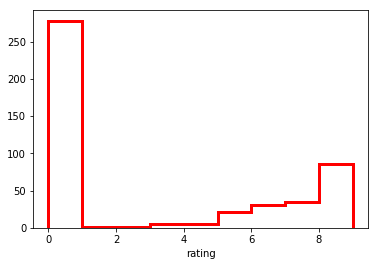

In [30]:
sns.distplot(df.rating,
             bins=range(10),
             hist_kws={"histtype": "step",
                       "linewidth": 3,
                       "alpha": 1,
                       "color": "r"},
             kde=False,

            )
            

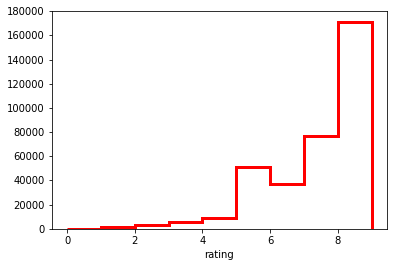

In [148]:
sns.distplot(df[df.rating!=0].rating,
             bins=range(10),
             hist_kws={"histtype": "step",
                       "linewidth": 3,
                       "alpha": 1,
                       "color": "r"},
             kde=False,
            )

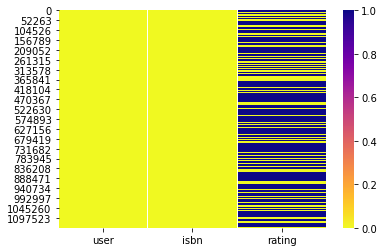

In [93]:
sns.heatmap(df==0,cmap='plasma_r')